# Predicting the sale price of bulldozers using machine learning 
 in htis notebook, we're going to go throught an example machine learning project with the goal of predicting the sale price of bulldozers


## 1. Problem Definition

For this dataset, the problem we're trying to solve, or better, the question we're trying to answer is,

> How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

## 2. Data

Looking at the [dataset from Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data), you can you it's a time series problem. This means there's a time attribute to dataset.

In this case, it's historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:
1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

## 3. Evaluation

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).

## 4. Features

Features are different parts of the data. During this step, you'll want to start finding out what you can about the data.

One of the most common ways to do this, is to create a **data dictionary**.

For this dataset, Kaggle provide a data dictionary which contains information about what each attribute of the dataset means. You can [download this file directly from the Kaggle competition page](https://www.kaggle.com/c/bluebook-for-bulldozers/download/Bnl6RAHA0enbg0UfAvGA%2Fversions%2FwBG4f35Q8mAbfkzwCeZn%2Ffiles%2FData%20Dictionary.xlsx) (account required) or view it on Google Sheets.

With all of this being known, let's get started! 

First, we'll import the dataset and start exploring. Since we know the evaluation metric we're trying to minimise, our first goal will be building a baseline model and seeing how it stacks up against the competition.

### Importing the data and preparing it for modelling

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

In [9]:
df = pd.read_csv('./Data/TrainAndValid.csv', low_memory = False)

In [11]:
df.shape

(412698, 53)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [17]:
df.isnull().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

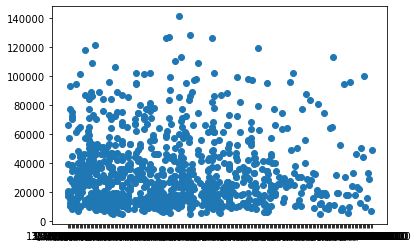

In [23]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000])

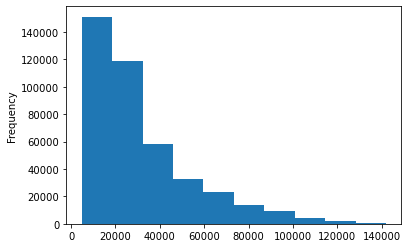

In [25]:
df.SalePrice.plot.hist()

### parsing dates

In [26]:
#
df = pd.read_csv('./Data/TrainAndValid.csv', low_memory=False, parse_dates=['saledate'])

In [29]:
df['saledate']

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
            ...    
412693   2012-03-07
412694   2012-01-28
412695   2012-01-28
412696   2012-03-07
412697   2012-01-28
Name: saledate, Length: 412698, dtype: datetime64[ns]

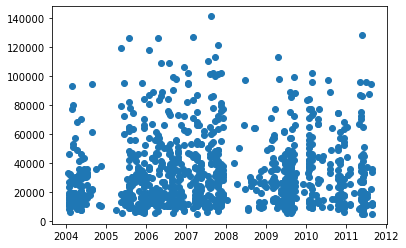

In [31]:
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000])

In [33]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
import seaborn as sns

### plotting missing data 

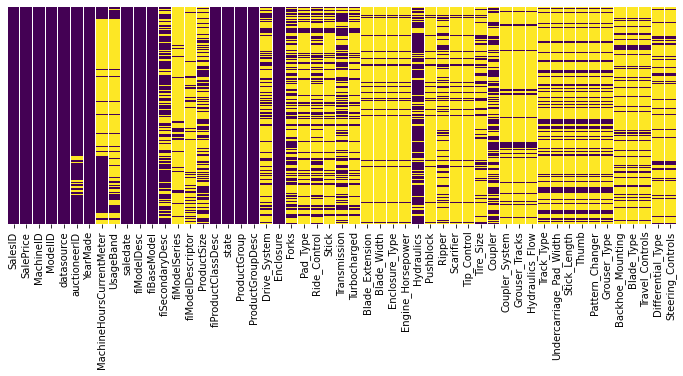

In [36]:
plt.figure(figsize = (12,4))
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

### Sort dataframe by date

In [38]:
df.sort_values(by=['saledate'], inplace = True, ascending = True)
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
233186,1728883,30000.0,1523610,9105,132,99.0,1986,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142491,1508502,21000.0,1153157,4138,132,99.0,1972,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Angle,None or Unspecified,NaN,NaN
115536,1452578,33000.0,1544443,3854,132,99.0,1974,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
92301,1403418,24000.0,1390168,7110,132,99.0,1986,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Copping original data to make changes

In [41]:
df_tmp = df.copy()

In [43]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
233186,1728883,30000.0,1523610,9105,132,99.0,1986,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142491,1508502,21000.0,1153157,4138,132,99.0,1972,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Angle,None or Unspecified,NaN,NaN
115536,1452578,33000.0,1544443,3854,132,99.0,1974,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
92301,1403418,24000.0,1390168,7110,132,99.0,1986,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Add datetime parameters for ´saledate´

In [45]:
df_tmp['saleYear'] = df_tmp.saledate.dt.year
df_tmp['saleMonth'] = df_tmp.saledate.dt.month
df_tmp['saleDay'] = df_tmp.saledate.dt.day
df_tmp['saleDayofWeek'] = df_tmp.saledate.dt.dayofweek
df_tmp['saleDayofYear'] = df_tmp.saledate.dt.dayofyear

In [48]:
df_tmp.head().T

,205615,233186,142491,115536,92301
SalesID,1646770,1728883,1508502,1452578,1403418
SalePrice,9500,30000,21000,33000,24000
MachineID,1126363,1523610,1153157,1544443,1390168
ModelID,8434,9105,4138,3854,7110
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1986,1972,1974,1986
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


#### removing saledate

In [50]:
df_tmp.drop('saledate',axis = 1, inplace = True)

In [52]:
df_tmp['state'].value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

### 5. Modelling

In [53]:
from sklearn.ensemble import RandomForestRegressor

In [57]:
model = RandomForestRegressor(n_jobs = -1,
                             random_state = 42)
model.fit(df_tmp.drop('SalePrice', axis = 1), df_tmp['SalePrice'])

ValueError: could not convert string to float: 'Medium'

In [60]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

### Convert Strings into Categories

One way to help turn all of our data into numbers is to convert the columns with the string datatype into a category datatype.

To do this we can use the [pandas types API](https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html#data-types-related-functionality) which allows us to interact and manipulate the types of data.

In [62]:
pd.api.types.is_string_dtype(df_tmp['UsageBand'])

True

In [66]:
#Printing string columns
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)
        

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


#### transforming all string categories into categories

In [67]:
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype('category').cat.as_ordered()

In [69]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [71]:
df_tmp['state'].cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [73]:
df_tmp['state'].cat.codes

205615    43
233186     8
142491     8
115536     8
92301      8
          ..
409901     4
405777     4
411889     4
411890     4
409203     4
Length: 412698, dtype: int8

In [75]:
df_tmp.isnull().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

### save Preprocessed data

In [76]:
df_tmp.to_csv('./Data/train_tmp.csv', index = False)

## Fill missing values 

#### Fill Numeric missing Values

In [78]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayofWeek
saleDayofYear


check for which numeric columns have null values

In [80]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


### fill numeric rows with the median

In [82]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            #add a binary column which tells us if the data was missing
            df_tmp[label+'_is_missing'] = pd.isnull(content)
            #fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

In [84]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [89]:
df_tmp['auctioneerID_is_missing'].value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

#### Filling and turning categorical values into numbers

In [93]:
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [96]:
pd.Categorical(df_tmp['state']).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

#### turn categorical variables into numbers and fill missing

In [97]:
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # add a binary column to indicate whether sample had missing values
        df_tmp[label+'_is_missing'] = pd.isnull(content)
        #turn categories into numbers and add +1 (missing = 0)
        df_tmp[label] = pd.Categorical(content).codes +1
        

In [101]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 101.1 MB


In [103]:
df_tmp.isnull().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

##### building ml model

In [107]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
233186,1728883,30000.0,1523610,9105,132,99.0,1986,0.0,0,4772,...,True,True,True,True,True,True,True,True,True,True
142491,1508502,21000.0,1153157,4138,132,99.0,1972,0.0,0,2347,...,True,True,True,True,True,False,False,False,True,True
115536,1452578,33000.0,1544443,3854,132,99.0,1974,0.0,0,1767,...,True,True,True,True,True,True,True,True,False,False
92301,1403418,24000.0,1390168,7110,132,99.0,1986,0.0,0,744,...,True,True,True,True,True,True,True,True,True,True


In [108]:
df_tmp.shape

(412698, 103)

In [109]:
%%time
#instantiate model
model = RandomForestRegressor(n_jobs = -1,
                             random_state = 42)
#fit the model
model.fit(df_tmp.drop('SalePrice', axis = 1), df_tmp['SalePrice'])

Wall time: 3min 15s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [110]:
#score the model in the training set
#close to one is ok
model.score(df_tmp.drop('SalePrice', axis = 1), df_tmp['SalePrice'])

0.9875966080326709

**Question:** Why doesn't the metric above isn't reliable?

## Splitting data into Train /Validation sets

In [113]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
233186,1728883,30000.0,1523610,9105,132,99.0,1986,0.0,0,4772,...,True,True,True,True,True,True,True,True,True,True
142491,1508502,21000.0,1153157,4138,132,99.0,1972,0.0,0,2347,...,True,True,True,True,True,False,False,False,True,True
115536,1452578,33000.0,1544443,3854,132,99.0,1974,0.0,0,1767,...,True,True,True,True,True,True,True,True,False,False
92301,1403418,24000.0,1390168,7110,132,99.0,1986,0.0,0,744,...,True,True,True,True,True,True,True,True,True,True


In [115]:
df_tmp['saleYear']

205615    1989
233186    1989
142491    1989
115536    1989
92301     1989
          ... 
409901    2012
405777    2012
411889    2012
411890    2012
409203    2012
Name: saleYear, Length: 412698, dtype: int64

In [118]:
df_tmp['saleYear'].value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [119]:
df_val = df_tmp[df_tmp['saleYear'] == 2012]
df_train = df_tmp[df_tmp['saleYear'] != 2012]

In [121]:
len(df_val), len(df_train)

(11573, 401125)

### Splitting into X and y
(train , valid "test")

In [140]:
X_train, y_train = df_train.drop('SalePrice', axis = 1), df_train['SalePrice']
X_valid, y_valid = df_val.drop('SalePrice', axis = 1), df_val['SalePrice']

In [125]:
X_train.shape, y_train.shape

((401125, 102), (401125,))

In [127]:
X_valid.shape, y_valid.shape

((11573, 102), (401125,))

### Building an evaluation function
<p> the competition uses RMSLE </p>

In [132]:
#absolute = real
#squared log = %
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

In [144]:
def rmsle(y_test, y_pred):
    """
    Caluculates Root mean squared error between true labels and predict labels
    """
    return np.sqrt(mean_squared_log_error(y_test, y_pred))

#create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {'Training MAE:': mean_absolute_error(y_train, train_preds),
              'Valid MAE: ': mean_absolute_error(y_valid, val_preds),
             'Training RMSLE:': rmsle(y_train, train_preds),
             'Valid RMSLE:': rmsle(y_valid, val_preds),
             'Training R^2': r2_score(y_train, train_preds),
             'valid R^2': r2_score(y_valid, val_preds)}
    return scores

#### Testing our model on a subset(to tune hyperparameters)

In [137]:

#change max_samples values 
model = RandomForestRegressor(n_jobs = -1, random_state=42, max_samples=10000)

In [138]:
%%time
model.fit(X_train, y_train)

Wall time: 8.31 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [145]:
#small model
show_scores(model)

{'Training MAE:': 5548.995840324089,
 'Valid MAE: ': 7179.6961392897265,
 'Training RMSLE:': 0.25737726780537257,
 'Valid RMSLE:': 0.29404344200903443,
 'Training R^2': 0.8610738743845616,
 'valid R^2': 0.8320179198265638}

### Hyperparameter Tuning with Randomized Search CV

In [146]:
from sklearn.model_selection import RandomizedSearchCV

In [153]:
%%time
#differetne RandomForestRegressor Hyperparameters
rf_grid = {'n_estimators': np.arange(10,100,10),
          'max_depth':[None,3,5,10],
          'min_samples_split': np.arange(2,20,2),
          'min_samples_leaf': np.arange(1,20,2),
          'max_features':[0.5,1,'sqrt','auto'],
          'max_samples':[10000]}
#instantiate RandommizedSearchCV model

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs = -1, random_state=42),
                              param_distributions = rf_grid,
                              n_iter = 2,
                              cv =5,
                              verbose = True)

rs_model.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   42.1s finished


Wall time: 45.5 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [154]:
#Find the best hiperparameters
rs_model.best_params_

{'n_estimators': 40,
 'min_samples_split': 10,
 'min_samples_leaf': 7,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': 10}

In [156]:
#evaluate the Randomized model
show_scores(rs_model)

{'Training MAE:': 6561.6003192528415,
 'Valid MAE: ': 7930.940833284878,
 'Training RMSLE:': 0.29437346004424436,
 'Valid RMSLE:': 0.3170576681597751,
 'Training R^2': 0.8120673374971012,
 'valid R^2': 0.7903414348004884}

### 100 iterations 

In [157]:
%%time
#differetne RandomForestRegressor Hyperparameters
rf_grid = {'n_estimators': np.arange(10,100,10),
          'max_depth':[None,3,5,10],
          'min_samples_split': np.arange(2,20,2),
          'min_samples_leaf': np.arange(1,20,2),
          'max_features':[0.5,1,'sqrt','auto'],
          'max_samples':[10000]}
#instantiate RandommizedSearchCV model

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs = -1, random_state=42),
                              param_distributions = rf_grid,
                              n_iter = 100,
                              cv =5,
                              verbose = True)

rs_model.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 27.5min finished


Wall time: 27min 38s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [160]:
rs_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

In [161]:
show_scores(rs_model)

{'Training MAE:': 5677.128381484627,
 'Valid MAE: ': 7252.6835413043555,
 'Training RMSLE:': 0.26186846373145856,
 'Valid RMSLE:': 0.2953362308179961,
 'Training R^2': 0.854451654506432,
 'valid R^2': 0.8274136581686987}

### Train a model with the best hyperparameters
found above in the search

In [165]:
%%time 

ideal_model = RandomForestRegressor(n_estimators=90,
                                   min_samples_split=10,
                                   min_samples_leaf=1,
                                   max_features='auto',
                                   max_depth = None,
                                   n_jobs = -1,
                                   random_state = 42)
#fit the ideal model
ideal_model.fit(X_train,y_train)

Wall time: 3min 1s


RandomForestRegressor(min_samples_split=10, n_estimators=90, n_jobs=-1,
                      random_state=42)

In [167]:
#trained with all examples
show_scores(ideal_model)

{'Training MAE:': 2462.1204735061074,
 'Valid MAE: ': 6077.281656935493,
 'Training RMSLE:': 0.12419237613737584,
 'Valid RMSLE:': 0.2527559568894702,
 'Training R^2': 0.9702012626753863,
 'valid R^2': 0.8745540354043267}

In [168]:
#trained with 10.000 examples
show_scores(model)

{'Training MAE:': 5548.995840324089,
 'Valid MAE: ': 7179.6961392897265,
 'Training RMSLE:': 0.25737726780537257,
 'Valid RMSLE:': 0.29404344200903443,
 'Training R^2': 0.8610738743845616,
 'valid R^2': 0.8320179198265638}

### Make Predictions on test data

#### import the test data

In [184]:
df_test = pd.read_csv('./Data/Test.csv', low_memory = False, parse_dates = ['saledate'])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [185]:
test_preds = ideal_model.predict(df_test)

ValueError: could not convert string to float: 'Low'

In [186]:
df_test.isnull().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

In [187]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

### Preprocessing the data

In [182]:
def preprocess_data(df):
    """
    Performs transformations on df and returns df
    """
    #1- manipulation datas
    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.month
    df['saleDay'] = df.saledate.dt.day
    df['saleDayofWeek'] = df.saledate.dt.dayofweek
    df['saleDayofYear'] = df.saledate.dt.dayofyear
    df.drop('saledate', axis = 1, inplace = True)
    
    
    for label, content in df.items():
        #2- fill numeric rows with median
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                #add a binary column which tells us if the data was missing
                df[label+'_is_missing'] = pd.isnull(content)
                #fill missing numeric values with median
                df[label] = content.fillna(content.median())

        #3- fill categorical missing data and turn into categories
        if not pd.api.types.is_numeric_dtype(content):            
            #add a binary column which tells us if the data was missing
            df[label+'_is_missing'] = pd.isnull(content)
            #add label+1 to encode missing data 
            df[label] = pd.Categorical(content).codes+1
                   
    return df

In [189]:
df_test =  preprocess_data(df_test)
df_test.shape

AttributeError: 'DataFrame' object has no attribute 'saledate'

In [195]:
df_test

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12452,6643171,2558317,21450,149,2,2008,3525.0,0,713,235,...,False,False,False,False,False,True,True,True,True,True
12453,6643173,2558332,21434,149,2,2005,3525.0,0,186,80,...,False,False,False,False,False,True,True,True,True,True
12454,6643184,2558342,21437,149,2,1000,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True
12455,6643186,2558343,21437,149,2,2006,3525.0,0,325,123,...,False,False,False,False,False,True,True,True,True,True


### we can find how the columns differ using sets

In [194]:

set(X_train.columns)-set(df_test.columns)

{'auctioneerID_is_missing'}

In [197]:
df_test['auctioneerID_is_missing']= False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


### Finally now our test dataframe has the same features of our training set , we can make predictions

In [199]:
test_preds = ideal_model.predict(df_test)

In [201]:
len(test_preds)

12457

#### Format predictions into same format Kaggle is after

In [203]:
df_preds = pd.DataFrame()
df_preds['SalesID'] = df_test['SalesID']
df_preds['SalesPrice'] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,21671.670863
1,1227844,19533.860571
2,1227847,49204.299566
3,1227848,82876.316627
4,1227863,43098.184122
...,...,...
12452,6643171,58214.196220
12453,6643173,12061.006867
12454,6643184,12359.798274
12455,6643186,17581.283572


In [204]:
df_preds.to_csv('./Data/predictions_to_post.csv', index = False)

## Feature Importance

Since we've built a model which is able to make predictions. The people you share these predictions with (or yourself) might be curious of what parts of the data led to these predictions.

This is where **feature importance** comes in. Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the **target variable**.

In our case, after our model learned the patterns in the data, which bulldozer sale attributes were most important for predicting its overall sale price?

Beware: the default feature importances for random forests can lead to non-ideal results.

To find which features were most important of a machine learning model, a good idea is to search something like "\[MODEL NAME\] feature importance".

Doing this for our `RandomForestRegressor` leads us to find the `feature_importances_` attribute.

Let's check it out.

In [209]:
print(len(ideal_model.feature_importances_))
ideal_model.feature_importances_

102


array([4.81022220e-02, 1.36042188e-02, 3.22913995e-02, 2.13723183e-04,
       3.56031452e-03, 2.67802302e-01, 2.67188135e-03, 9.08520794e-04,
       2.00671283e-02, 8.11729556e-02, 5.28390216e-02, 4.48028285e-03,
       3.29473259e-03, 2.33312281e-01, 3.92406453e-02, 7.06693581e-03,
       1.86486907e-04, 1.81784847e-04, 1.74890598e-03, 8.55453704e-03,
       3.33744207e-04, 2.79109563e-05, 4.68933881e-04, 1.68922426e-04,
       1.52315325e-03, 2.06854414e-05, 4.00219820e-04, 5.77253114e-03,
       4.66085773e-04, 2.17159261e-04, 3.08937190e-03, 2.90941472e-03,
       2.16256640e-03, 2.93316613e-03, 5.31013288e-04, 1.51502387e-03,
       7.96521487e-04, 1.36906889e-02, 7.94219218e-06, 3.34288983e-06,
       1.63707327e-04, 9.36705079e-04, 1.05919603e-03, 6.24406331e-04,
       1.91945231e-04, 3.70287658e-04, 2.18416071e-04, 1.44068925e-03,
       8.56103104e-04, 1.60636107e-04, 2.13317275e-04, 7.67276539e-02,
       2.16801760e-03, 7.00957710e-03, 3.35433683e-03, 1.28984262e-02,
      

In [210]:
import seaborn as sns

# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns, "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")


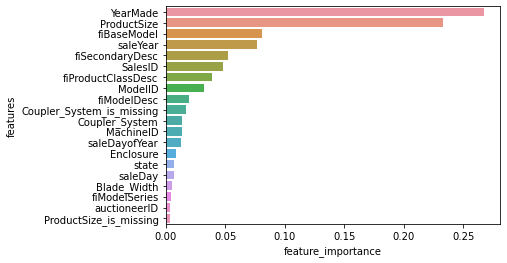

In [212]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [216]:
#unique values
df_tmp['SalesID'].value_counts().sum()

412698

In [219]:
df_tmp['SalesID'].isna().sum()

0

### Next Steps, remove Features that might mislead the model

